In [1]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install --upgrade mplfinance
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
import gc
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 65.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

In [85]:

def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")


def get_crypto_syms():
   # 'all_cryptocurrencies_au','all_cryptocurrencies_ca','all_cryptocurrencies_eu','all_cryptocurrencies_gb','all_cryptocurrencies_in',
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   # print(len(symbols))
   # pieces = 15
   # new_arrays = np.array_split(symbols, pieces)
   return symbols


def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")


def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now


def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):

    address = f"/content/data/{file}"
    data = pd.read_csv(address)
    data = data.dropna()
    dfs = []
    suggs = []
    if len(data.columns) == 7:
      data = data.iloc[:, 1:]
    data = np.array(data)
    data = data.astype(float)
    for i in range(each_row_past, data.shape[0]-which_future_or_past):

        rows = data[i-each_row_past:i, :4]

        past_candles = []
        #for z in range(1, how_many_past_candles+1):
        #  past_candles.append(data[i-z][3])
        #past_candles = sum(past_candles)/len(past_candles)
        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append(data[i+z][3])
        next_candles = sum(next_candles)/len(next_candles)
        if next_candles > data[i-1][3]:
          suggs.append(1)
        else:
          suggs.append(0)

        x = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close"])
        del rows
        del past_candles
        del next_candles
        dfs.append(x)
        del x
    del data

    index = 0
    all_n = np.array(dfs).shape[0]
    for df in dfs:
        date_list = []
        rrng = np.array(df).shape[0]
        for i in range(rrng):
            date_list.append(datetime.fromordinal(
                datetime.today().toordinal()+i).strftime('%Y-%m-%d'))
        df.index = date_list
        df.index.name = "Date"
        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{suggs[index]}.png"
        if len(df)[0] >= 52:
          df = df[52:,:]

          mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                           scale_padding=0.2, returnfig=True, savefig=address, tight_layout=True,figsize =(4,3),mav=(5,10,26,52))
        
        plt.close("all")
        del df
        del date_list
        del rrng
        del i
        del right_now
        gc.collect()



        index = index + 1
        if index % 10 == 0:
            print(f"{index}/{all_n}", end=" ")
        if index % 160 == 0:
          print(" ")

    print("")
    del dfs
    del suggs
    del index
    del all_n
    gc.collect()



def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name


In [73]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
#symbols = ["msft","goog"]
download_data(symbols,"10d","1h")

Symbols : 1500
Data Folder Removed
 


Files In Data : 6
Processing File:
File Number 1: 

SystemError: ignored

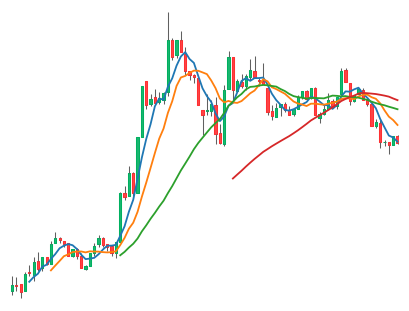

In [91]:
how_many_future_candles = 5
how_many_past_candles = 5
each_row_past = 90

global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles

folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

In [88]:
#folder_name = '122227'



label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (100, 80)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)

data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")

nytrain = []
nytest = []
yn = 0
nn = 0

for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1

yTrain = np.array(nytrain)
yTest = np.array(nytest)

print(f"yn: {yn} nn: {nn}")

(420, 80, 100)
xTrain : 336 \ xTest : 84
yn: 111 nn: 309


In [89]:
model = Sequential()

model.add(Conv2D(128,  (2, 2),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,   (2, 2),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(900,activation="relu"))
model.add(Dense(900,activation="relu"))
model.add(Dense(900,activation="relu"))
model.add(Dense(900,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 79, 99, 128)       640       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 39, 49, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 38, 48, 32)        16416     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 19, 24, 32)       0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 14592)             0         
                                                                 
 dense_99 (Dense)            (None, 900)             

In [90]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(xTrain,yTrain,batch_size=8,epochs=20,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)


Epoch 1/20
42/42 [==============================] - 2s 27ms/step - loss: 0.6519 - accuracy: 0.7083 - val_loss: 0.5963 - val_accuracy: 0.7500
Epoch 2/20
42/42 [==============================] - 1s 12ms/step - loss: 0.5929 - accuracy: 0.7321 - val_loss: 0.5588 - val_accuracy: 0.7500
Epoch 3/20
42/42 [==============================] - 0s 12ms/step - loss: 0.5816 - accuracy: 0.7321 - val_loss: 0.5389 - val_accuracy: 0.7500
Epoch 4/20
42/42 [==============================] - 1s 22ms/step - loss: 0.5127 - accuracy: 0.7351 - val_loss: 0.4495 - val_accuracy: 0.8214
Epoch 5/20
42/42 [==============================] - 1s 23ms/step - loss: 0.4076 - accuracy: 0.8244 - val_loss: 0.3240 - val_accuracy: 0.8810
Epoch 6/20
42/42 [==============================] - 1s 23ms/step - loss: 0.2556 - accuracy: 0.8958 - val_loss: 0.2290 - val_accuracy: 0.9048
Epoch 7/20
42/42 [==============================] - 1s 12ms/step - loss: 0.1741 - accuracy: 0.9315 - val_loss: 0.2252 - val_accuracy: 0.8929
Epoch 8/20
42